In [44]:
#### Set up markdown style
from IPython.core.display import HTML
HTML("""
<style>

div.text_cell_render { /* Customize text cells */
font-family: 'Times New Roman';
font-size:1.1em;
line-height:1.2em;
padding-left:.2em;
padding-right:1em;
}
</style>
""")

## A Simple Analysis of Search Rankings

The goal of this short project was to explore some of the characteristics of search listings on eBay and determine whether the description of the objects (among other variables) affected the order of the search results.

I used a search of "blue 4 person tent waterproof" as my test case. This is something outside of my usual eBay user profile (I don't recall ever having searched for camping gear on eBay before). The line of reasoning is that the preferences for this category of items may be less affected by my user history/affinities and more by the characteristics of the products themselves.


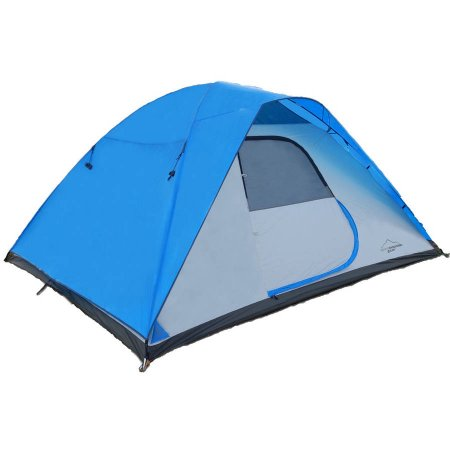

In [35]:
from IPython.display import Image
Image(filename='./tent.jpeg')

### Data Acquisition

First, I loaded in some of my usual analysis packages...

In [1]:
%matplotlib inline
import os
import html
import urllib2, cookielib
from urllib2 import Request
import re, string
import operator
import image
from IPython.display import Image, display
import numpy as np
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import numpy
from pylab import *
from matplotlib import *
import pandas as pd
import sklearn

In order to get some data to work with, I coded up a little webscrape to get the top search results for "blue 4 person tent waterproof" on eBay. This allowed me to get the page address for each of the search results for this query: 

In [2]:
def search_results(webpage):
    site = webpage

    hdr = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
           'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
           'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
           'Accept-Encoding': 'none',
           'Accept-Language': 'en-US,en;q=0.8',
           'Connection': 'keep-alive'}

    req = urllib2.Request(site, headers=hdr)

    try:
        page = urllib2.urlopen(req)
    except urllib2.HTTPError, e:
        print 'Exception 1 - Search did not work'

    ### read in page
    content = page.read()
    ### find pages with top search results
    findstr = r'<h3 class="lvtitle"><a href="http://www.ebay.com/itm/'+'[^"]*'+'"  class="vip"'
    result = re.findall(findstr, content)
    return result

Next, a bit of code took those URLs from the search results page and extracted various information for each of those products - things like the product description, the number of items sold, the rate of eBay user views of the product (if noted on page), the number of users watching that product, the rating of the seller of that item, and the price.

While these are only a few (easy to scrape) features to work with, the hope was to gain a little bit of basic insight into how the search results are ordered/determined. In particular, I was interested in whether the *relevancy* of the description of the item to its "category" (in this case, camping gear) was in any way related to its order in the search results, or any of the other factors.

In [15]:
def lookup_description(result, n=5):
    if len(result)!=0:
        #### for each of n pages, grab description
        res = []; views = []; tm=[]; n_sold = []; seller_fdbk = []; n_watch = []; price = []; sale = []
        for j in arange(0,n):
            #### grab page, using previous result, to go to webpage 
            nextpage = result[j][29:-14]
            hdr = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
                   'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
                   'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
                   'Accept-Encoding': 'none',
                   'Accept-Language': 'en-US,en;q=0.8',
                   'Connection': 'keep-alive'}
            req = urllib2.Request(nextpage, headers=hdr)

            try:
                page = urllib2.urlopen(req)
            except urllib2.HTTPError, e:
                print 'Exception 2 - Bad link'

            content = page.read()  ### read page

            ### find string that has description
            findstr = r'<meta Property="og:description" Content="'+'[^"]*'+'| eBay!" />'
            result2 = re.findall(findstr, content)
            if len(result2)>0:
                result2 = (atleast_1d(result2)[0][41:-7]).lower()#.strip('')
                for i in ['&quot', '[.,:;]','&apos']:
                    result2 = re.sub(i, '', result2)
                res.append(result2)
            else: res.append(' ')

            ### find views per day
            findstr = r'>'+'[^"]*'+' viewed per '+'[^"]*'+'</span>'
            st = re.findall(findstr, content)
            if len(st)>0:
                #print st[0], st[0][1:3], st[0][-11:-7]
                views.append(float(st[0][1:3])); tm.append(st[0][-11:-7].strip())
            else: views.append(NaN); tm.append(NaN)

            ### number sold
            findstr = r'">'+'[\d]*'+' sold'
            st = re.findall(findstr, content)
            if len(st)>0:
                n_sold.append(int(st[0][2:-5]))
            else: n_sold.append(NaN)

            ### seller % positive feedback
            findstr = '>'+'[^"]*'+'Positive feedback<'
            st = re.findall(findstr, content)
            if len(st)>0:
                seller_fdbk.append(float((st[0][1:4]).strip('%')))
            else: seller_fdbk.append(NaN)

            ### number watching
            findstr = '>'+'[^"]*'+'</span> watching</span>'
            st = re.findall(findstr, content)
            if len(st)>0:
                n_watch.append(int(st[0][1:-23]))
            else: n_watch.append(NaN)
                
            ### price
            findstr = 'itemprop="price"  style="" content="'+'[^"]*'+'">'
            st = re.findall(findstr, content)
            if len(st)>0:
                price.append(float(st[0][36:-2]))
            else: price.append(NaN)
                
    return res, views, tm, n_sold, seller_fdbk, n_watch, price
#lookup_description(res[20:21], n=1)

 
Last, there is a piece of code that uses fuzzy matching to determine how many "relevant" camping words are present in the item description. This is, of course, somewhat arbitrary and subjective based on the list of "camping words" that I googled. Nevertheless, it should give some idea of whether item descriptions are focused on the product and the experience it advertises.

In the mehod in which I have set up the feature, a greater number of relevant camping words in the product description leads to a greater "relevance score".

In [4]:
def get_camping_relevance(res):
    camping = np.loadtxt('./camping_words.txt', delimiter=',', dtype='S99')
    camping = [wd.strip().lower() for wd in camping]
    total = []; descrp_lens = []
    for j, desc in enumerate(res):
        tot = 0; descrp_lens.append(len(desc))
        for i, word in enumerate(desc.split()):
            for k,ls in enumerate(camping):
                if fuzz.token_sort_ratio(word, ls)>=90:
                    #print ls, word
                    tot += 1
        total.append(tot)
    return total, descrp_lens

### Extracting/cleaning the data 

All right, now the access to the data is all set up -- let's get into it. 

In [16]:
#page1 = 'http://www.ebay.com/sch/i.html?_from=R40&_sacat=888%27&_nkw=blue+4+person+tent+waterproof&_pgn=1&_skc=50&rt=nc'
#res = search_results(page1)
#for i in range(2,13):
#    page2 = 'http://www.ebay.com/sch/i.html?_from=R40&_sacat=888%27&_nkw=blue+4+person+tent+waterproof&_pgn='+str(i)+'&_skc=50&rt=nc'
#    res2 = search_results(page2)
#    res = concatenate((res,res2))
#res = unique(res)

txt, views, tm, n_sold, seller_fdbk, n_watch, price = lookup_description(res, n=len(res))
rel, length_desc = get_camping_relevance(txt)

... And into a dataframe it goes.

In [17]:
DF = pd.DataFrame()
DF['Description'] = txt; DF['Relevance'] = rel; DF['Length'] = length_desc; DF['Price'] = price
DF['NumSold'] = n_sold; DF['NumWatching'] = n_watch; DF['SellerRating'] = seller_fdbk# - mean(seller_fdbk))/std(seller_fdbk)

#### the views are listed (if they are listed) by hour or by day -- so here we convert to make all into hours
vrate = []
for i,n in enumerate(views):
    if tm[i]=='hour':
        vrate.append(n*24.)
    elif tm[i]=='day':
        vrate.append(n)
    elif tm[i]==NaN or tm[i]==0:
        vrate.append(NaN)
    else:
        vrate.append(NaN)
DF['ViewRate'] = vrate  ### number of viewers per day, if provided
DF['Rank'] = DF.index   ### the order of the results - from 1 to N results, with 1 being the first result on the page

#### I decided to fill the non-existent values with zeros rather than interpolate
#### As the data is imbalanced, it threw off the eventual model by cutting the predictive power in half
#DF.interpolate(method='linear', limit_direction='both', inplace=True)
DF.fillna(value=0.,inplace=True)

In [18]:
### save results to a static file for my own purposes
#import pickle
#DF.to_pickle('ResultsTable.pickle')
DF = pd.read_pickle('ResultsTable.pickle')

A brief look at the first few rows of the dataset:

In [20]:
DF.head()

,Description,Relevance,Length,Price,NumSold,NumWatching,SellerRating,ViewRate,Rank
0,comfortable compact and lightweight take this ...,4,193,32.91,0.0,0.0,98.0,0.0,0
1,this tent is a must on your next outdoor adven...,7,247,13.33,20.0,10.0,98.0,0.0,1
2,waterproof &amp uv resistant 190t polyester us...,7,264,36.99,3.0,3.0,99.0,0.0,2
3,comfortable compact and lightweight take this ...,4,193,0.00,7.0,8.0,98.0,0.0,3
4,a funny and unforgettable camping starts from ...,3,229,45.50,0.0,0.0,98.0,0.0,4


### Exploratory Analysis

 
Now our data is scraped from the web and cleaned up into a nice dataframe. Time for an exploratory look at the data (the plot below).

It's clear (as expected) that the numbers of those watching items and the number sold are largely either not watched/sold, or not mentioned on the page (this could an option I am unaware of - for the seller to decide to show this information to the prospective buyer or not). Regardless, this makes the data highly imbalanced. Unfortunately, with barely 100 data points, there is not much to resample from where there are non-null values. Clearly, this will make building a model on so few points/features difficult.

The relevance has a nice range of values. The number watching/sold and view rate have very similar shapes (I'll return to this point in a moment). The description lengths suggest that most sellers use up to close the maximum length. Only one product description is longer than 460 characters; the rest are under 325. This one product description is so far beyond the range it is likely to be an anomaly.

The seller rating is intruiging. I would expect it to not have a lot of predicting power, as there is an extremely small range of values (95% to 100%). I wonder how much effect these ratings actually have on customer perception of a seller/product if they are all essentially equivalent (clustered in the top 5% possible rating).

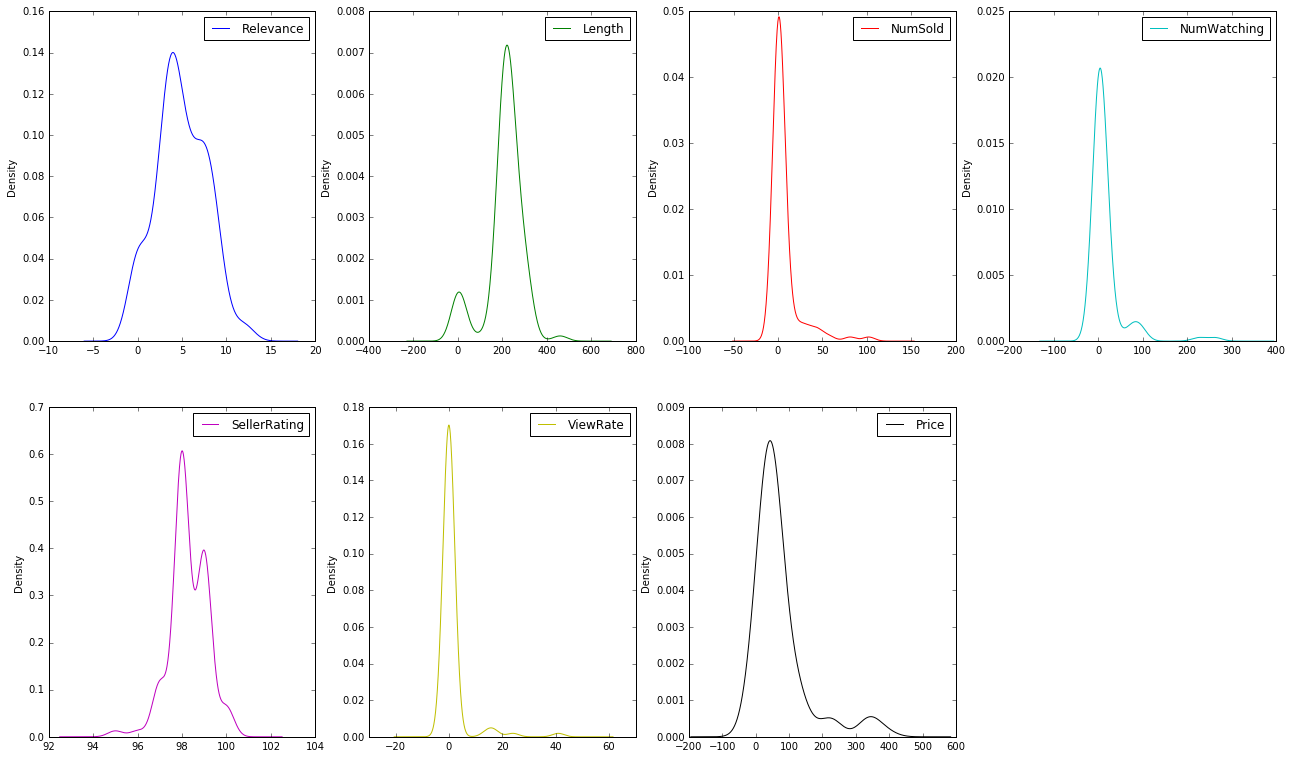

In [21]:
df = pd.DataFrame(DF, columns=(['Relevance','Length','NumSold','NumWatching','SellerRating','ViewRate','Price']))
df.plot(kind='density', subplots=True, layout=(2,4), figsize=(22,13), sharex=False, sharey=False,)
plt.show()

 
At first glance, I found it fascinating that the price appears bimodal. Looking at the very few products above $250, it appears from the descriptions that perhaps they are intended for more than four people or for modifying SUVs. Being larger in size/more complex, the tents naturally would cost more. Nothing else is unusual or unique about this small set of more expensive products.

The descriptions of these expensive products, below:

In [24]:
[i for i in DF['Description'][(DF['Price']>250)]]

['this coleman 12-person double hub instant tent has enough room for you and 11 of your best friends it has a center height of 64 so it will accommodate most adults it has enough space for four queen airbeds ',
 'sportz suv tent by napier\xc2\xae 9 x 9 x 725 capacity 5/7 person blue/gray/blue color napier\xe2\x80\x99s suv tents are the only suv tents on the market with a detachable vehicle sleeve this tent create the ultimate camping oasis wherever you take it ',
 'ozark trail 14-person 4-room cabin tent in addition each of the tents four rooms has a separate door so no more tripping over your friends on a late-night bathroom run it sets up easily with two people in 20 minutes ',
 'sportz full size suv 82000 tentmodel 82000 mnufacturer napier the sportz suv 82000 tent quickly transforms your cuv suv or minivan into a comfortable home away from home no more having to unzip and zip tent doors and open and close vehicle doors to get something you need from your vehicle ',
 'the sportz suv

Time to look at which features may be related to the order of the product search.

In [25]:
DF.corr()

,Relevance,Length,Price,NumSold,NumWatching,SellerRating,ViewRate,Rank
Relevance,1.000000,0.602398,-0.168399,-0.144159,-0.141799,0.054366,-0.142224,-0.061019
Length,0.602398,1.000000,0.030578,-0.237044,-0.184554,-0.157096,-0.116932,0.059735
Price,-0.168399,0.030578,1.000000,-0.160043,-0.079805,0.125032,-0.035037,0.285503
NumSold,-0.144159,-0.237044,-0.160043,1.000000,0.921601,0.142787,0.571463,-0.083325
NumWatching,-0.141799,-0.184554,-0.079805,0.921601,1.000000,0.171139,0.564944,-0.043191
SellerRating,0.054366,-0.157096,0.125032,0.142787,0.171139,1.000000,0.171412,0.093042
ViewRate,-0.142224,-0.116932,-0.035037,0.571463,0.564944,0.171412,1.000000,-0.111679
Rank,-0.061019,0.059735,0.285503,-0.083325,-0.043191,0.093042,-0.111679,1.000000


The initial look at the data shows very weak correlations between the features and the order of the results. The ranking of each product seems to certainly be affected by price, with more expensive products being placed further down the list. This could be related to my particular affinity on eBay towards lower price points.

The number watching and number sold do not appear to be strongly related to the product ranking (though they are understandably correlated very strongly to each other), suggesting popularity of the items by these metrics do not predict much about where the product appears in the list of search results.

As predicted, the seller rating has very little effect on the ranking. Again, being in such a small range of values (5% near perfect) makes it an unlikely characteristic to sway consumers or differentiate between sellers.

While relevance is correlated to length (clearly lengthier descriptions have more room for relevant camping vocabulary), it does not appear to affect the ranking. This is somewhat disappointing, as I was hoping this would be a indicator of appeal to the consumer, as well as a possible method by which sellers could improve their search result rankings.

### A Brief Model

Now, to pull together a rough model from these features, I use a ridge L2 classifier. This allows for multi-variate classification and weighting of the feature coefficients relative to their importance (with weaker features being penalized in a relative way). Correlated features will have similar coefficients.

The main benefit of this approach (aside from accounting for multicollinearity) is that the model will likely be more stable and less affected by small changes in the data (thereby also avoiding overfitting). My favorite part about this approach is that the results remain easily interpretable, unlike other possible model choices.

In [28]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

df2 = pd.DataFrame(DF, columns=['Relevance', 'Length', 'Price', 'NumSold', 'NumWatching', 'SellerRating', 'ViewRate'])
df2.fillna(value=0.,inplace=True)
df2.head()

,Relevance,Length,Price,NumSold,NumWatching,SellerRating,ViewRate
0,4,193,32.91,0.0,0.0,98.0,0.0
1,7,247,13.33,20.0,10.0,98.0,0.0
2,7,264,36.99,3.0,3.0,99.0,0.0
3,4,193,0.00,7.0,8.0,98.0,0.0
4,3,229,45.50,0.0,0.0,98.0,0.0


In [29]:
####### split into training and test sets here... need a random sample, not a straight split, because of rankings
import random; seed(15)
msk = np.random.rand(len(df2)) < 0.8
Xtrain = df2[msk]; ytrain = DF['Rank'][msk]
Xtest = df2[~msk]; ytest = DF['Rank'][~msk]

ridge = Ridge(alpha=.1, normalize=True, solver='sag', tol=0.0000001)
ridge.fit(Xtrain, pd.Series(ytrain))
print "Ridge model:", ridge.coef_, '\n'#, ridge.intercept_, ridge.score

#predd = ridge.predict(Xtest)
print 'R^2 Value:', ridge.score(Xtest, ytest), '\n'
print 'Predicted Rankings:', [int(i) for i in ridge.predict(Xtest)]
print 'Actual Rankings:', list(ytest)

Ridge model: [-1.06336228  0.03379483  0.06141493 -0.09182911 -0.00653026  2.14251676
 -0.4053794 ] 

R^2 Value: 0.20195242883 

Predicted Rankings: [46, 39, 46, 46, 48, 51, 42, 41, 60, 60, 70, 72, 42]
Actual Rankings: [0, 10, 13, 14, 20, 25, 50, 68, 70, 74, 78, 79, 88]


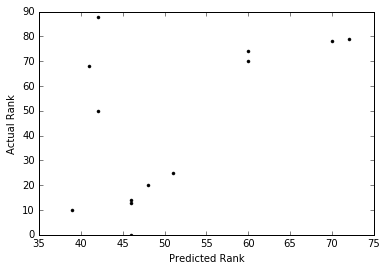

In [32]:
plot([int(i) for i in ridge.predict(Xtest)], list(ytest), 'k.')
xlabel('Predicted Rank'); ylabel('Actual Rank')

The model is, sadly, quite awful. It has some *relative* predictive power, but little in the way of *absolute* predictive power. Of course, this is fairly unsurprising considering the initial assessment showing little correlation.

There are a number of factors, unaccounted for, which could also be useful features or constraints -- sales, promoted products, and the enormous list of user preferences. If I had more time to scrape additional features, the rating of each product, the reviews/sentiment of reviews, and whether the item is discounted in price would likely be the best next choice for predictive features to add to the model. Whether or not shipping takes more than a few days could also be an important factor.

I was interested if the ranking was sensitive to the description's relevance to the category -- clearly it is not. However, if it had been, it could help sellers modify minor things like word choice to gain a better place for their products in rankings.

If a larger dataset of items and features were available, I would look further at whether the relevance was related to the frequency or time spent looking at a particual product and its ranking, taking into account the customer's history of purchase frequency, price point, etc. If time allows, I would like to repeat this analysis for varying search queries to compare the results.
